Se instala SpaCY para apoyarnos en la aplicacion de las tecnicas necesarias para la limpieza de texto del campo "Observacion"

In [14]:
%%bash
# 1. Creamos el venv en ~/venv_spacy
python3 -m venv ~/venv_spacy

# 2. Activamos el venv
source ~/venv_spacy/bin/activate

# 3. Actualizamos pip / setuptools / wheel
pip install --upgrade pip setuptools wheel

In [1]:
%%bash
# Activamos el venv
source ~/venv_spacy/bin/activate

# Instalar ipykernel en el venv (si no lo tienes aún)
pip install ipykernel --only-binary=:all:

# Registrar el kernel para Jupyter
python -m ipykernel install --user --name spacy-env --display-name "Python (spaCy venv)"

Installed kernelspec spacy-env in /home/jovyan/.local/share/jupyter/kernels/spacy-env


In [2]:
%%bash
# 1. Activamos el venv
source ~/venv_spacy/bin/activate

# 2. Instalamos spaCy 3.8.7 usando exclusivamente ruedas binarias
pip install spacy==3.8.7 --only-binary=:all:


In [3]:
%%bash
# 1. Activamos el venv
source ~/venv_spacy/bin/activate

# 2. Instalamos el modelo medium 3.8.0 usando únicamente ruedas binarias
pip install \
  "https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.8.0/es_core_news_md-3.8.0-py3-none-any.whl" \
  --only-binary=:all:


  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.8.0/es_core_news_md-3.8.0-py3-none-any.whl (42.3 MB)


In [4]:
%%bash
# 1. Activamos el venv
source ~/venv_spacy/bin/activate

# 2. Instalamos las librerías de datos y procesamiento estadístico/textual
pip install --upgrade pip setuptools wheel

# Librerías principales:
pip install \
    pandas \
    numpy \
    scipy \
    scikit-learn \
    python-Levenshtein

# spaCy y modelos en español (si aún no los tienes):
pip install spacy==3.8.7 --only-binary=:all:
pip install \
  "https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.8.0/es_core_news_md-3.8.0-py3-none-any.whl" \
  --only-binary=:all:
pip install \
  "https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl" \
  --only-binary=:all:


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 249.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 224.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import re
from pandas import ExcelWriter
from collections import Counter
import datetime


from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.feature_selection import mutual_info_classif

from Levenshtein import distance as levenshtein

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
import es_core_news_sm
import es_core_news_md

In [6]:
nlp = spacy.load('es_core_news_md')
nlp2 = spacy.load('es_core_news_sm')

In [7]:


# Definición de tipos según esquema proporcionado
dtype = {
    'ID_ORDEM_SERVICO': str,
    'ID_UC': str,
    'Estado Instalacion': str,
    'Uso': str,
    'Actividad Economica': str,
    'Estado OT': str,
    'Observacion': str,
    'Efectividad': str,
    'Causa Efectividad': str,
    'Causa Evento': str,
    'Analisis Lectura': str,
    'Menor a Promedio': str,
    'ID_Accion': str,
    'Nombre Accion': str,
    'Consumo promedio': float,
    'Lectura en Visita': float,
    'Ultimo Valor Leido': float,
    'Oportunidad Ejecucion': float,
    'Oportunidad Descargue': float,
    'Diferencia Lectura': float,
    'Dias entre lecturas': float,
    'Promedio Consumo dia': float,
    'Promedio Dia Historico': float,
    'Score Lectura': float,
    'Score Promedio': float,
    'Total Puntaje': float
}
parse_dates = ['Fecha Generacion', 'Fecha Ejecucion', 'FechaDescargue', 'Fecha Ultima Lectura']

# Carga del archivo Excel
path = "s3://proyectointegradorfinal/raw/Base_Entrenamiento.csv"


In [8]:
%%bash
# 1. Activamos el venv
source ~/venv_spacy/bin/activate

# 2. Instalamos los paquetes necesarios para leer de S3
pip install fsspec s3fs --only-binary=:all:


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 222.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.4.0
    Uninstalling urllib3-2.4.0:
      Successfully uninstalled urllib3-2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 [s3fs]2m13/16 [aiohttp]]ols]


In [ ]:
df = pd.read_csv(path, dtype=dtype, parse_dates=parse_dates, na_values=['#VALUE!', '#DIV/0!'])

In [11]:
df_diccionario = pd.read_csv('s3://proyectointegradorfinal/raw/DiccionarioInicial.csv')
# Specify the encoding to 'latin-1' or 'ISO-8859-1' to correctly read the file
df_Stop_words = pd.read_csv('s3://proyectointegradorfinal/raw/Stopwords.csv', sep=';', encoding='latin-1')



# Cargar el archivo
stopwords= pd.read_csv(
    's3://proyectointegradorfinal/raw/Stopwords.csv',
    sep=';',
    encoding='latin-1'
)

# Obtener la primera columna por posición (independiente del nombre)
df_Stop_words = df_Stop_words.iloc[:, 0].dropna()


In [12]:
df_Stop_words.head(10)

0             1
1             3
2            ?1
3           aal
4           abb
5         acaso
6         accon
7         acion
8    actualidad
9         adeas
Name: Stopword, dtype: object

se cuentan nulos

In [13]:
# Conteo de valores faltantes por columna
missing = df.isnull().sum().sort_values(ascending=False)
missing.head(10)


Causa Efectividad       1032
Promedio Consumo dia     272
Menor a Promedio         272
Score Promedio           272
Total Puntaje            272
Analisis Lectura         262
Score Lectura            262
Observacion              255
Causa Evento             255
Fecha Generacion         255
dtype: int64

Un 35% de datos perdidos en Causa Efectividad sugiere revisar el proceso de ingreso de información o formularios para capturar esta causa.

El faltante de ~8–9% en variables numéricas y de texto es manejable, pero podría introducir sesgos si no se imputa adecuadamente.

In [14]:
# Eliminación de registros sin fechas
df_clean = df.dropna(subset=parse_dates)
df_clean.shape

(2895, 30)

Filas originales: (3150, 30)

Tras limpieza: (2895, 30)

Análisis:

Se descartan 255 registros con datos temporales incompletos para mantener integridad en análisis cronológicos.

se eliminan ceros donde todas las variables sean 0 o todas las categoricas 0, no nos aportan informacion al modelo

In [15]:
# Listado de columnas categóricas y numéricas
categorical_cols = ['Estado Instalacion','Uso','Actividad Economica','Estado OT',
                    'Causa Efectividad','Analisis Lectura','Observacion',
                    'Causa Evento','Menor a Promedio']
numeric_cols = df_clean.select_dtypes(include='float').columns.tolist()

# Eliminar filas donde todas las categóricas están vacías
df = df_clean.dropna(how='all', subset=categorical_cols)
# Eliminar filas donde todas las numéricas están vacías
df = df_clean.dropna(how='all', subset=numeric_cols)

df.shape

(2895, 30)

Se eliminan registros que no contienen información en ninguna columna categórica, asegurando relevancia en atributos cualitativos.

Se eliminan registros que no aportan valores numéricos, preservando la calidad de los análisis cuantitativos.

In [16]:
# Conteo de valores faltantes por columna
missing = df.isnull().sum().sort_values(ascending=False)
missing.head(10)

Causa Efectividad       777
Promedio Consumo dia     17
Menor a Promedio         17
Score Promedio           17
Total Puntaje            17
Analisis Lectura          7
Score Lectura             7
Fecha Ejecucion           0
Fecha Generacion          0
ID_ORDEM_SERVICO          0
dtype: int64

se  etiqueta a causa efectiva como desocnocido, asegurando relevante ade atirbutos cualitativos

In [17]:
# Imputación de 'Desconocido' en Causa Efectividad
df.fillna({'Causa Efectividad': 'No Aplica'}, inplace=True)
df['Causa Efectividad'].value_counts()

Causa Efectividad
No fraude                                            1922
No Aplica                                             777
Agua Propia                                            39
Requiere investigación por otro equipo de trabajo      37
Otras Fuentes                                          28
No autorizan trabajo                                   26
Inspeccion No Realizada                                23
Atendido con otra orden de trabajo o solicitud         18
No asistencia dueño o representante                    16
No hay quien informe                                    4
Información errada                                      2
No se localiza elemento de red                          2
No se contacta cliente                                  1
Name: count, dtype: int64

In [18]:
# Conteo de valores faltantes por columna
missing = df.isnull().sum().sort_values(ascending=False)
missing.head(10)

Total Puntaje           17
Promedio Consumo dia    17
Menor a Promedio        17
Score Promedio          17
Score Lectura            7
Analisis Lectura         7
Fecha Ejecucion          0
FechaDescargue           0
ID_ORDEM_SERVICO         0
ID_UC                    0
dtype: int64

etiquetamos como desconocido a analisis de lectura para asegurar lo mismo

In [19]:
# Etiquetado de texto faltante como 'Desconocido'
for col in [ 'Analisis Lectura', 'Observacion', 'Causa Evento']:
    df.loc[df[col].isna(), col] = 'Desconocido'

# Etiquetado de texto faltante como 'Desconocido'
for col in ['Causa Efectividad', 'Analisis Lectura', 'Observacion', 'Causa Evento']:
    df[col] = df[col].fillna('Desconocido')

In [20]:
# Conteo de valores faltantes por columna
missing = df.isnull().sum().sort_values(ascending=False)
missing.head(10)

Total Puntaje           17
Promedio Consumo dia    17
Menor a Promedio        17
Score Promedio          17
Score Lectura            7
ID_ORDEM_SERVICO         0
Fecha Ejecucion          0
FechaDescargue           0
Fecha Ultima Lectura     0
ID_UC                    0
dtype: int64

el conteo de nulos por  variable diminuyo notablemente, vamos a trabajr con estos datos

In [21]:
# Cálculo de estadísticos básicos y sesgo
stats = df.select_dtypes(include='float').agg(['mean','std','skew','kurtosis']).T
print(stats)

                                mean           std       skew     kurtosis
Consumo promedio        2.363661e+01  1.109682e+02  16.389880   366.281519
Lectura en Visita       1.622364e+08  5.286552e+09  37.692934  1427.208960
Ultimo Valor Leido      7.607300e+03  4.321606e+04  16.271223   324.555013
Oportunidad Ejecucion   7.981693e+00  3.747933e+00   0.683611     1.170656
Oportunidad Descargue   6.272884e-01  1.170775e+00   3.223469    27.483806
Diferencia Lectura      1.622329e+08  5.286552e+09  37.692934  1427.208946
Dias entre lecturas     4.208359e+01  8.247468e+02  53.749066  2890.970631
Promedio Consumo dia    7.778794e+07  3.739241e+09  53.577514  2872.999923
Promedio Dia Historico  7.878872e-01  3.698939e+00  16.389880   366.281519
Score Lectura           5.202216e+00  2.989643e+00   0.881143    -1.053319
Score Promedio          2.892981e+00  2.788765e+00   0.794465    -1.369777
Total Puntaje           8.078527e+00  5.177632e+00   0.806390    -1.000955


Interpretación de resultados:

Alta asimetría positiva (skew >> 1) en variables como Consumo promedio, Lectura en Visita, Diferencia Lectura y Días entre lecturas indica distribuciones muy sesgadas a la derecha, con pocos casos de valores extremadamente altos.

Curtosis elevada (kurtosis >> 3) en estas mismas variables refleja colas pesadas y presencia de outliers extremos que pueden distorsionar análisis basados en varianza.

Variables como Score Lectura, Score Promedio y Total Puntaje muestran asimetrías moderadas y curtosis cerca o por debajo de 0, sugiriendo distribuciones más cercanas a la normal.



In [22]:
from IPython.display import display
# Frecuencia de categorías principales
for col in ['Estado Instalacion','Uso','Actividad Economica','Estado OT','Menor a Promedio']:
    vc = df[col].value_counts()
    df_vc = vc.to_frame(name='count')
    display(df_vc)



,count
Estado Instalacion,
ActivoCon suministro,2850
RetiradoPara suspensión,12
RetiradoSuspendida,10
RetiradoRetirado por falta de pago,2
InactivoRetirado,2
053820006000430000-SUAGPO,1
061410003000300201-SUAGPO,1
074427005000710000-SUAGPO,1
077522403100300000-SUAGPO,1


,count
Uso,
Residencial,1562
Comercial,718
Industrial,314
Oficial,166
Exenta,110
Calibre: 1/2,17
Autoconsumo,4
Area Comun,3
Calibre: 2,1


,count
Actividad Economica,
Residencial estrato 1,493
Residencial estrato 2,491
Residencial estrato 3,304
Comercial,265
Industrial,105
...,...
Actividades de impresion,1
Gestión de instalaciones deportivas,1
"Actividades relacionadas con la promocion y produccion de espectaculos deportivos por cuenta propia, o por escuelas de deporte",1


,count
Estado OT,
Cerrada,2435
DescargadaParcial,460


,count
Menor a Promedio,
Igual o mayor a Promedio,1970
Menor a Promedio,908


Estado Instalacion: “ActivoCon suministro” representa el 98% de los casos; los estados de retiro y suspensión son minoritarios (<1%). Se agrupan bajo la categoría "Inactivo/Retiros" para simplificar la variable.

Uso: “Residencial” (54%) y “Comercial” (25%) dominan; “Industrial” (11%), “Oficial” y “Exenta” (<10% combinadas) pueden consolidarse en "Otros Usos" para reducir niveles.

Actividad Economica: Los tres estratos residenciales suman alrededor del 85% del total, mientras que “Comercial” e “Industrial” aportan menos del 12%. Se crea una categoría "Otros Sectores" para actividades de baja frecuencia.

Estado OT: “Cerrada” (84%) y “DescargadaParcial” (16%) muestran un balance aceptable y no requieren agrupación.

Menor a Promedio: La clase “Igual o mayor a Promedio” (68%) es mayoritaria frente a “Menor a Promedio” (32%); este desequilibrio moderado es manejable en modelado.

In [23]:

# Estado Instalacion → “Inactivo/Retiros” para todo lo que no sea “ActivoCon suministro”
df['Estado Instalacion'] = df['Estado Instalacion'].apply(
    lambda x: x if 'ActivoCon' in str(x) else 'Inactivo/Retiros'
)

# Uso → conservar “Residencial” y “Comercial”, el resto pasa a “Otros Usos”
df['Uso'] = df['Uso'].where(
    df['Uso'].isin(['Residencial', 'Comercial','Industrial']),
    'Otros Usos'
)

# Actividad Economica → conservar solo los tres estratos residenciales, el resto a “Otros Sectores”
df['Actividad Economica'] = df['Actividad Economica'].where(
    df['Actividad Economica'].isin([
        'Residencial estrato 1',
        'Residencial estrato 2',
        'Residencial estrato 3',
        'Comercial',
        'Industrial'
    ]),
    'Otros Sectores'
)


In [24]:
df['Estado Instalacion'].value_counts()

Estado Instalacion
ActivoCon suministro                           2850
Inactivo/Retiros                                 45
Name: count, dtype: int64

In [25]:
df['Causa Evento'].value_counts()

Causa Evento
No fraude                                             1770
Anomalia - Se surte de otra instalacion                180
Anomalia - Medidor parado/funcionando mal              179
Anomalía - Medidor en contraflujo                      129
No Aplica                                              125
Anomalia - Instalacion directa (Cliente EPM)           105
Predio solo o desocupado                                64
Anomalia - Medidor destruido                            60
Fraude - Manipulacion del medidor                       60
Agua Propia                                             49
Fraude - Instalacion clandestina (Con/sin medidor)      31
Anomalia - No se ubica medidor                          25
Anomalia - Agua Propia combinada con agua EPM           22
Anomalía - Posible anomalía del medidor                 21
No autorizan trabajo                                    18
Anomalía - Medidor Comunitario                          11
Anomalía - Medidor obsoleto                

In [26]:
%%bash
source ~/venv_spacy/bin/activate

pip install matplotlib seaborn --only-binary=:all:


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 164.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 147.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 208.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [seaborn]m8/9 [seaborn]ib]


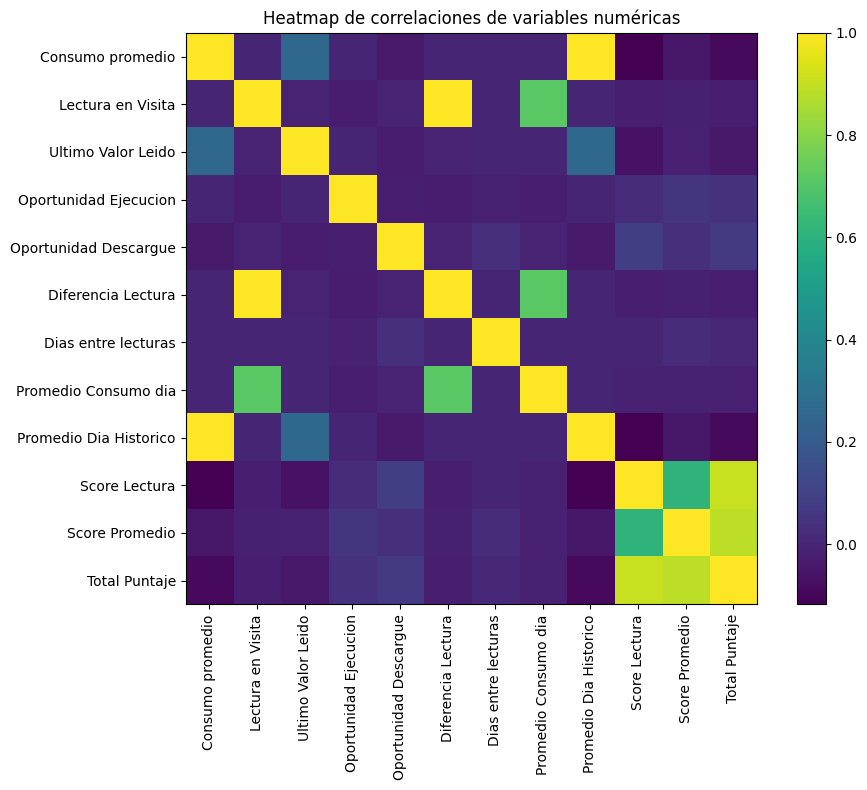

In [27]:
# Celda X: Mapa de correlaciones de variables numéricas

import matplotlib.pyplot as plt

# Calcula la matriz de correlación
corr = df.select_dtypes(include='float').corr()

# Dibuja el heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation='none')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Heatmap de correlaciones de variables numéricas')
plt.tight_layout()
plt.show()


Consumo promedio y Promedio Día Histórico tienen correlación ~1. Miden esencialmente lo mismo (consumo promedio calculado vs histórico), por lo que podemos dejar sólo una de ellas.

Lectura en Visita, Diferencia Lectura y Días entre lecturas también muestran correlaciones muy altas (>0.9) entre sí, pues a mayor tiempo transcurrido, la diferencia entre lecturas y la lectura actual crecen de manera casi lineal.

Score Lectura, Score Promedio y Total Puntaje se agrupan en la esquina inferior derecha con correlaciones entre 0.8 y 0.9. Como suenan solaparse (métricas compuestas de puntajes), conviene elegir una sola o combinarlas vía PCA.

Oportunidad Ejecucion y Oportunidad Descargue mantienen correlaciones moderadas (<0.3) con el resto; aportan información propia y deberían conservarse.

Cualquier par con correlación cercana a 0 indica ausencia de relación lineal; esas variables pueden mantenerse porque añaden diversidad al modelo.

In [28]:
# 1. ¿Existe df_diccionario?
print("¿Está df_diccionario definido?", 'df_diccionario' in globals())

# 2. ¿Qué columnas tiene?
print("Columnas de df_diccionario:", df_diccionario.columns.tolist())

# 3. Muestra las primeras filas para ver estructura
print(df_diccionario.head())


¿Está df_diccionario definido? True
Columnas de df_diccionario: ['Palabra', 'Sinonimo']
       Palabra   Sinonimo
0    abandonar  abandonar
1     avandono  abandonar
2      abarcar    abarcar
3     abarrote   abarrote
4  abastecenla  abastecer


In [29]:
variables = []
dict_final = {}

palabras_nuevas = ['.']
remplazos = {'.': '.'}

# Agrupamos por “Palabra” para que cada clave quede con su lista completa de sinónimos
dict_sinonimos = (
    df_diccionario
    .groupby("Palabra")["Sinonimo"]
    .apply(list)
    .to_dict()
)

# Si df_Stop_words es un DataFrame con una columna “StopWord”, primero sacamos esa Serie:
if isinstance(df_Stop_words, pd.DataFrame):
    df_Stop_words = df_Stop_words["StopWord"]

dict_stopword = set(df_Stop_words.tolist())


Se definen las funciones necesarias para la limpieza de texto

In [30]:


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Funciones de limpieza
def depurar_Observacion(obs):
    if "FECHA VIS" not in obs or "RAZON" not in obs:
        return obs
    try:
        pos_ini = obs.find("FECHA VIS") + 20
        sub = obs[pos_ini:]
        pos_fin = sub.find("RAZON")
        return sub[:pos_fin - 2].strip()
    except:
        return obs

def depurar_marca_causa_evento(obs):
    return obs.split("*CausaEvento")[0].strip() if "*CausaEvento" in obs else obs

def quitar_informacion_sello(texto):
    return re.sub(r'#\w+\d+', '', texto)

def quitar_numericos(texto):
    return re.sub(r'[0-9]+', '', texto)

def limpiar_caracteres(texto):
    return re.sub(r'[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ ]+', ' ', texto).strip()

def escoger_palabras(texto):
    if not texto or not isinstance(texto, str):
        return ''
    doc = nlp(texto)
    interes = ['NOUN', 'ADJ', 'VERB', 'ADP']
    frase = []
    for token in doc:
        if token.text.lower() in ['no', 'si']:
            frase.append(token.text.lower())
        elif token.pos_ in interes and len(token.text) > 2:
            frase.append(token.lemma_.lower())
    return " ".join(frase)


In [31]:
def diccionario(frase):
    f = []
    doc = nlp(frase)
    for token in doc:
        palabra = token.text.lower()
        if palabra in dict_stopword:
            continue
        elif palabra in palabras_nuevas:
            f.append('imputada')
        elif palabra in remplazos:
            f.append(remplazos[palabra])
        elif palabra in dict_sinonimos:
            # Append the first synonym from the list
            f.append(dict_sinonimos[palabra][0])
        # Check if the word itself is a synonym in the dictionary values
        elif any(palabra in syn_list for syn_list in dict_sinonimos.values()):
            f.append(palabra)
        else:
            mejor = ''
            porcentaje = 0
            for key in dict_sinonimos:
                dist = levenshtein(palabra, key)
                max_len = max(len(palabra), len(key))
                sim = 1 - (dist / max_len)
                if sim > porcentaje:
                    porcentaje = sim
                    # Store the first synonym from the list
                    mejor = dict_sinonimos[key][0]
            if porcentaje >= 0.7:
                remplazos[palabra] = mejor
                f.append(mejor)
            else:
                palabras_nuevas.append(palabra)
                f.append('imputada')
    return " ".join(f)


In [32]:
def pipeline_texto(texto):
    if not isinstance(texto, str) or texto.strip() == "":
        return ""
    texto = depurar_Observacion(texto)
    texto = depurar_marca_causa_evento(texto)
    texto = quitar_informacion_sello(texto)
    texto = quitar_numericos(texto)
    texto = limpiar_caracteres(texto)
    texto = escoger_palabras(texto)
    texto = diccionario(texto)
    return texto

In [33]:
df.columns

Index(['ID_ORDEM_SERVICO', 'ID_UC', 'Estado Instalacion', 'Uso',
       'Actividad Economica', 'Fecha Generacion', 'Fecha Ejecucion',
       'FechaDescargue', 'Fecha Ultima Lectura', 'Estado OT', 'Observacion',
       'Efectividad', 'Causa Efectividad', 'Causa Evento', 'Consumo promedio',
       'Lectura en Visita', 'Ultimo Valor Leido', 'Oportunidad Ejecucion',
       'Oportunidad Descargue', 'Diferencia Lectura', 'Dias entre lecturas',
       'Promedio Consumo dia', 'Analisis Lectura', 'Promedio Dia Historico',
       'Menor a Promedio', 'Score Lectura', 'Score Promedio', 'Total Puntaje',
       'ID_Accion', 'Nombre Accion'],
      dtype='object')

In [34]:
df['Observaciones_Limpias'] = df['Observacion'].apply(pipeline_texto)

In [35]:
df[['Observacion', 'Observaciones_Limpias']]

,Observacion,Observaciones_Limpias
0,"Se encuentra vivienda sin medidor, con servici...",encontrar vivienda sin medidor servicio direct...
1,Carlos Jaramillo \nMedidor Water tech de ½ ser...,serie lectura posicion correcta sin signo mani...
2,Yonatan Giraldo predio solo no hay quien sumin...,predio no suministrar informacion medidor inst...
3,SEBASTIAN BUILES FECHA VISITA :24/07/2021 PAP ...,no no personal mantenimiento disponible parar ...
4,Jorge grueso clase de uso no residencial activ...,clase imputada no residencial actividad econom...
...,...,...
3145,Medidor serie#2020576875 con lectura 00024 con...,serie lectura sello bueno ilegible registra pr...
3146,Carlos Jaramillo... medidor Water tech de 1/2 ...,medidor serie lectura sello bueno posicion cor...
3147,Medidor serie#2020575691 con lectura 00017 con...,serie lectura llave contencion cerrado sello b...
3148,SEBASTIAN BUILES\nSe visita dirección en insta...,visita direccion residencial predio serie lect...


In [36]:
def agrupar_causaevento(causa):
    no_revisado = ['No Aplica', 'No autorizan trabajo', 'Otras Fuentes', 'Información errada']
    if causa in no_revisado:
        return 'No revisado'
    elif causa == 'No fraude':
        return 'Normal'
    else:
        return 'Anomalia'



In [37]:
df['Grupo Evento'] = df['Causa Evento'].apply(agrupar_causaevento)

In [38]:
df['Grupo Evento'].value_counts()

Grupo Evento
Normal         1770
Anomalia        978
No revisado     147
Name: count, dtype: int64

In [39]:
df.head(5)

,ID_ORDEM_SERVICO,ID_UC,Estado Instalacion,Uso,Actividad Economica,Fecha Generacion,Fecha Ejecucion,FechaDescargue,Fecha Ultima Lectura,Estado OT,...,Analisis Lectura,Promedio Dia Historico,Menor a Promedio,Score Lectura,Score Promedio,Total Puntaje,ID_Accion,Nombre Accion,Observaciones_Limpias,Grupo Evento
0,EPMA3935989-1,12285549,ActivoCon suministro,Residencial,Otros Sectores,2021-09-10,2021-09-13,2021-09-13,2021-08-25 00:00:00,DescargadaParcial,...,Parado,0.066667,Menor a Promedio,10.0,7.0,17.0,35.389,1053_C_Otro_Canal_200820212,encontrar vivienda sin medidor servicio direct...,Anomalia
1,EPMA3877311-1,12285712,ActivoCon suministro,Otros Usos,Otros Sectores,2021-07-23,2021-08-05,2021-08-05,2021-08-25 00:00:00,Cerrada,...,Lectura Normal,0.400000,Igual o mayor a Promedio,3.0,1.0,4.0,34.791,2528_C_CaidaConsumo_220720210,serie lectura posicion correcta sin signo mani...,Normal
2,EPMA3894208-1,12285932,ActivoCon suministro,Residencial,Otros Sectores,2021-08-06,2021-08-19,2021-08-19,2021-09-01 00:00:00,Cerrada,...,Lectura Normal,0.200000,Igual o mayor a Promedio,3.0,1.0,4.0,35.096,1053_C_Otro_Canal_050820211,predio no suministrar informacion medidor inst...,Anomalia
3,EPMA3860292-1,12286097,ActivoCon suministro,Otros Usos,Otros Sectores,2021-07-09,2021-07-24,2021-07-27,2021-08-12 00:00:00,Cerrada,...,Lectura Normal,0.400000,Igual o mayor a Promedio,3.0,1.0,4.0,34.568,2528_C_CaidaConsumo_080720210\t,no no personal mantenimiento disponible parar ...,No revisado
4,EPMA3901950-1,12286401,ActivoCon suministro,Otros Usos,Otros Sectores,2021-08-14,2021-08-31,2021-08-31,2021-08-21 00:00:00,Cerrada,...,Lectura Normal,3.133333,Igual o mayor a Promedio,3.0,1.0,4.0,35.262,3050_C_CaidaConsumo_130820210\t,clase imputada no residencial actividad econom...,Normal


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2895 entries, 0 to 3149
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_ORDEM_SERVICO        2895 non-null   object        
 1   ID_UC                   2895 non-null   object        
 2   Estado Instalacion      2895 non-null   object        
 3   Uso                     2895 non-null   object        
 4   Actividad Economica     2895 non-null   object        
 5   Fecha Generacion        2895 non-null   datetime64[ns]
 6   Fecha Ejecucion         2895 non-null   datetime64[ns]
 7   FechaDescargue          2895 non-null   datetime64[ns]
 8   Fecha Ultima Lectura    2895 non-null   object        
 9   Estado OT               2895 non-null   object        
 10  Observacion             2895 non-null   object        
 11  Efectividad             2895 non-null   object        
 12  Causa Efectividad       2895 non-null   object       

In [41]:


def chi_sq_fisher(d):
    datos=d.copy()
    lista_categoricos=['Estado Instalacion','Uso','Actividad Economica','Analisis Lectura']
    y=datos['Grupo Evento']
    categoricos_datos = datos[lista_categoricos]


    # Calcular mutual information para cada variable categórica con el target
    mi = mutual_info_classif(categoricos_datos.apply(lambda x: x.astype('category').cat.codes), y.loc[categoricos_datos.index], discrete_features=True)
    mi_dict = dict(zip(lista_categoricos, mi))

    i = 0
    while i < len(lista_categoricos) - 1:
        col1 = lista_categoricos[i]
        col2 = lista_categoricos[i+1]

        at1 = categoricos_datos[col1].astype('category')
        at2 = categoricos_datos[col2].astype('category')

        tabla = pd.crosstab(at1, at2)
        matriz = tabla.values

        # Chi2 test
        stat, p, dof, esperada = chi2_contingency(matriz)
        nf, nc = esperada.shape
        menor_a_cinco = (esperada < 5).sum()
        porcentaje = menor_a_cinco / (nf * nc)

        if porcentaje > 0.20:
            # Usar test de Fisher solo para tablas 2x2 (o pequeñas)
            if matriz.shape == (2, 2):
                _, p_value = fisher_exact(matriz)
                test_p = p_value
                test_name = "Fisher"
            else:
                # Si tabla no es 2x2, saltamos Fisher
                test_p = p
                test_name = "Chi2 (sin Fisher)"
        else:
            test_p = p
            test_name = "Chi2"

        # Dependencia fuerte si p < 0.05
        if test_p < 0.05:
            # Redundancia detectada
            # Escoger cuál columna eliminar según mutual info con y
            mi_col1 = mi_dict[col1]
            mi_col2 = mi_dict[col2]

            if mi_col1 < mi_col2:
                eliminar = col1
                lista_categoricos.pop(i)
                # También eliminar de dict mi
                mi_dict.pop(col1)
                # No incrementar i, para revisar nuevo elemento en posición i
            else:
                eliminar = col2
                lista_categoricos.pop(i+1)
                mi_dict.pop(col2)
                # i sigue igual para la siguiente comparación

            print(f"Eliminada columna redundante: {eliminar} (test: {test_name}, p={test_p:.4f})")
        else:
            i += 1

    return lista_categoricos


In [42]:
col_categoricas=chi_sq_fisher(df)

Eliminada columna redundante: Estado Instalacion (test: Chi2, p=0.0000)


In [43]:
col_categoricas

['Uso', 'Actividad Economica', 'Analisis Lectura']

In [44]:
def categorizar_y(x):
  if x=='Normal':
    return 0
  elif x=='Anomalia':
    return 1
  else:
    return 2

In [45]:
df['CausaClasificada']=df['Grupo Evento'].apply(categorizar_y)

In [46]:
df.head(5)

,ID_ORDEM_SERVICO,ID_UC,Estado Instalacion,Uso,Actividad Economica,Fecha Generacion,Fecha Ejecucion,FechaDescargue,Fecha Ultima Lectura,Estado OT,...,Promedio Dia Historico,Menor a Promedio,Score Lectura,Score Promedio,Total Puntaje,ID_Accion,Nombre Accion,Observaciones_Limpias,Grupo Evento,CausaClasificada
0,EPMA3935989-1,12285549,ActivoCon suministro,Residencial,Otros Sectores,2021-09-10,2021-09-13,2021-09-13,2021-08-25 00:00:00,DescargadaParcial,...,0.066667,Menor a Promedio,10.0,7.0,17.0,35.389,1053_C_Otro_Canal_200820212,encontrar vivienda sin medidor servicio direct...,Anomalia,1
1,EPMA3877311-1,12285712,ActivoCon suministro,Otros Usos,Otros Sectores,2021-07-23,2021-08-05,2021-08-05,2021-08-25 00:00:00,Cerrada,...,0.400000,Igual o mayor a Promedio,3.0,1.0,4.0,34.791,2528_C_CaidaConsumo_220720210,serie lectura posicion correcta sin signo mani...,Normal,0
2,EPMA3894208-1,12285932,ActivoCon suministro,Residencial,Otros Sectores,2021-08-06,2021-08-19,2021-08-19,2021-09-01 00:00:00,Cerrada,...,0.200000,Igual o mayor a Promedio,3.0,1.0,4.0,35.096,1053_C_Otro_Canal_050820211,predio no suministrar informacion medidor inst...,Anomalia,1
3,EPMA3860292-1,12286097,ActivoCon suministro,Otros Usos,Otros Sectores,2021-07-09,2021-07-24,2021-07-27,2021-08-12 00:00:00,Cerrada,...,0.400000,Igual o mayor a Promedio,3.0,1.0,4.0,34.568,2528_C_CaidaConsumo_080720210\t,no no personal mantenimiento disponible parar ...,No revisado,2
4,EPMA3901950-1,12286401,ActivoCon suministro,Otros Usos,Otros Sectores,2021-08-14,2021-08-31,2021-08-31,2021-08-21 00:00:00,Cerrada,...,3.133333,Igual o mayor a Promedio,3.0,1.0,4.0,35.262,3050_C_CaidaConsumo_130820210\t,clase imputada no residencial actividad econom...,Normal,0


In [47]:
from sklearn.preprocessing import StandardScaler

def correlacion_numericas(datos):
    lista_num_final = list()
    scaler = StandardScaler()
    datos1 = datos.copy()
    datos1.dropna(inplace=True)
    y=datos1['CausaClasificada']
    datos1.drop(columns=['CausaClasificada','Oportunidad Ejecucion','Oportunidad Descargue'], inplace=True)


    numericos1 = datos1.select_dtypes(include=[np.number])

    listacolumnas = list(numericos1.columns)
    print(listacolumnas)

    numericos_copia1 = numericos1.copy()
    scaler.fit(numericos_copia1)
    numericos_copia = pd.DataFrame(scaler.transform(numericos_copia1), columns=listacolumnas)

    i = 0
    cantcolumnas = len(listacolumnas)

    while i < cantcolumnas - 1:
        col_i = listacolumnas[i]
        at1 = numericos_copia[col_i]

        n = i + 1
        while n < cantcolumnas:
            col_n = listacolumnas[n]
            at2 = numericos_copia[col_n]

            correlacion = at1.corr(at2)

            if np.isnan(correlacion):
                # Eliminar columna i si correlacion no es válida
                print(f"Eliminada columna {col_i} (correlacion nan)")
                listacolumnas.pop(i)
                cantcolumnas -= 1
                i -= 1
                break
            elif abs(correlacion) > 0.7:
                # Evaluar también correlación con target
                corr_target_i = datos1[col_i].corr(y)
                corr_target_n = datos1[col_n].corr(y)

                # Si corr con target es nan, lo consideramos 0 para no favorecerlo
                if np.isnan(corr_target_i):
                    corr_target_i = 0
                if np.isnan(corr_target_n):
                    corr_target_n = 0

                if corr_target_i < corr_target_n:
                    # Eliminar columna i
                    print(f"Eliminada columna {col_i} (correlacion {correlacion:.2f})")
                    listacolumnas.pop(i)
                    cantcolumnas -= 1
                    i -= 1
                    break
                else:
                    # Eliminar columna n
                    print(f"Eliminada columna {col_n} (correlacion {correlacion:.2f})")
                    listacolumnas.pop(n)
                    cantcolumnas -= 1
                    n -= 1
            else:
                n += 1

        i += 1

    lista_num_final = listacolumnas
    return lista_num_final


In [48]:
col_numericas=correlacion_numericas(df)

['Consumo promedio', 'Lectura en Visita', 'Ultimo Valor Leido', 'Diferencia Lectura', 'Dias entre lecturas', 'Promedio Consumo dia', 'Promedio Dia Historico', 'Score Lectura', 'Score Promedio', 'Total Puntaje']
Eliminada columna Consumo promedio (correlacion 1.00)
Eliminada columna Lectura en Visita (correlacion 1.00)
Eliminada columna Promedio Consumo dia (correlacion 0.71)
Eliminada columna Total Puntaje (correlacion 0.90)


In [49]:
col_numericas

['Ultimo Valor Leido',
 'Diferencia Lectura',
 'Dias entre lecturas',
 'Promedio Dia Historico',
 'Score Lectura',
 'Score Promedio']

In [50]:
df.columns

Index(['ID_ORDEM_SERVICO', 'ID_UC', 'Estado Instalacion', 'Uso',
       'Actividad Economica', 'Fecha Generacion', 'Fecha Ejecucion',
       'FechaDescargue', 'Fecha Ultima Lectura', 'Estado OT', 'Observacion',
       'Efectividad', 'Causa Efectividad', 'Causa Evento', 'Consumo promedio',
       'Lectura en Visita', 'Ultimo Valor Leido', 'Oportunidad Ejecucion',
       'Oportunidad Descargue', 'Diferencia Lectura', 'Dias entre lecturas',
       'Promedio Consumo dia', 'Analisis Lectura', 'Promedio Dia Historico',
       'Menor a Promedio', 'Score Lectura', 'Score Promedio', 'Total Puntaje',
       'ID_Accion', 'Nombre Accion', 'Observaciones_Limpias', 'Grupo Evento',
       'CausaClasificada'],
      dtype='object')

In [51]:
X_text = df['Observaciones_Limpias'].astype(str)

In [52]:
X_text.head()

0    encontrar vivienda sin medidor servicio direct...
1    serie lectura posicion correcta sin signo mani...
2    predio no suministrar informacion medidor inst...
3    no no personal mantenimiento disponible parar ...
4    clase imputada no residencial actividad econom...
Name: Observaciones_Limpias, dtype: object

In [53]:


vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)
X_text_vec = vectorizer.fit_transform(df['Observaciones_Limpias'])

#vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))

# Use the X_text Series directly as it already contains the text data
X_text_vec = vectorizer.fit_transform(X_text)

# CountVectorizer returns a sparse matrix, convert to dense DataFrame if needed for concatenation
# Ensure index is aligned with the original data, which is stored in X_text's index
X_text_df = pd.DataFrame(X_text_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=X_text.index)

In [54]:
X_text_df.head()

,abarrote,abastecer,abastecer acometida,abastecer agua,abastecer hacer,abastecer mayorca,abrir,abrir llave,accesorio,accion,...,vivienda no,vivienda sin,vivir,vivir persona,vivir predio,vivir solo,volver,zona,zona agua,zona comun
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.336542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Suponiendo que tu DataFrame se llama df
column_names = X_text_df.columns.tolist()

# Crear un corpus uniendo los nombres (puedes separarlos con espacios)
corpus = " ".join(column_names)


In [56]:
%%bash
source ~/venv_spacy/bin/activate
pip install wordcloud --only-binary=:all:


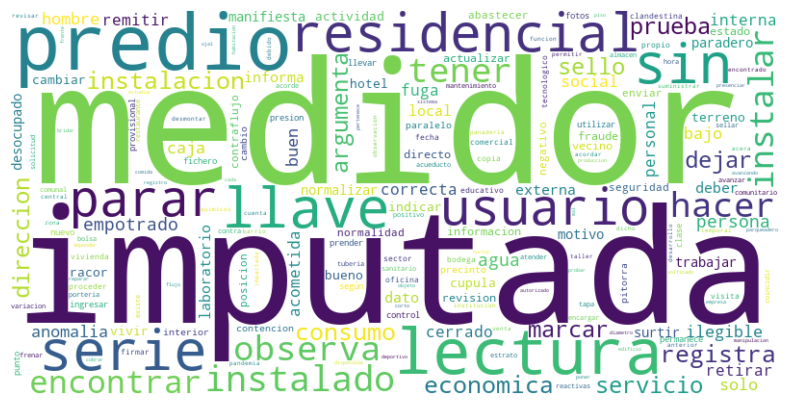

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear la wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Mostrar la imagen
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quita los ejes
plt.show()

In [58]:
suma_columnas = X_text_df.sum(numeric_only=True)

# 2. Convertir en DataFrame y ordenar
suma_ordenada = (
    suma_columnas
    .reset_index()
    .rename(columns={'index': 'columna', 0: 'suma'})
    .sort_values(by='suma', ascending=False)
    .reset_index(drop=True)
)

# Mostrar el resultado
print(suma_ordenada)

                    columna        suma
0                        no  228.927724
1                   medidor  186.306912
2                  imputada  181.002725
3                    predio  156.847994
4                   lectura  139.516513
...                     ...         ...
1880      desmontar revisar    0.962135
1881  seguridad desempotrar    0.945640
1882       lectura proceder    0.915108
1883       encontrar objeto    0.897749
1884      servicio pericial    0.897156

[1885 rows x 2 columns]


In [59]:
X_test_Filtradas = X_text_df.loc[:, X_text_df.sum() >= 1]

columnas_eliminadas = X_text_df.columns[X_text_df.sum() < 1]
print("Columnas eliminadas por baja aparición:")
print(columnas_eliminadas.tolist())


Columnas eliminadas por baja aparición:
['acera cobrar', 'desmontar revisar', 'emplear motivo', 'encontrar objeto', 'fuga usuario', 'laboratorio no', 'lectura proceder', 'medidor temporal', 'racor desmontar', 'revisar no', 'seguridad desempotrar', 'servicio pericial']


In [60]:
X_test_Filtradas.shape

(2895, 1873)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def analisis_varianza_producto_interno(df_numericas, umbral_producto=0.9, umbral_eigen=0.01, plot=True, reducir=True):

    df = df_numericas.dropna().copy()
    columnas = df.columns.tolist()

    # 1) Escalar datos
    X_scaled = StandardScaler().fit_transform(df)
    cov_matrix = np.cov(X_scaled.T)

    # 2) Usar np.linalg.eigh en lugar de eig, para garantizar valores reales
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # eigenvalues ya viene ordenado de menor a mayor; si prefieres descender, invierte:
    # eigenvalues = eigenvalues[::-1]
    # eigenvectors = eigenvectors[:, ::-1]

    # 3) Asegurar que sean reales (descartar pequeñas partes imaginarias)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    # 4) Redundancia por producto interno
    redundantes_pi = set()
    n = len(columnas)
    for i in range(n):
        if columnas[i] in redundantes_pi:
            continue
        v1 = X_scaled[:, i]
        for j in range(i + 1, n):
            if columnas[j] in redundantes_pi:
                continue
            v2 = X_scaled[:, j]
            prod = np.dot(v1, v2) / len(v1)  # normalizado
            if abs(prod) >= umbral_producto:
                var1 = np.var(v1)
                var2 = np.var(v2)
                redundantes_pi.add(columnas[j] if var1 >= var2 else columnas[i])

    # 5) Redundancia por eigenvalores bajos (cuando (eigen < umbral))
    redundantes_eigen = [columnas[i] for i, eig in enumerate(eigenvalues) if eig < umbral_eigen]

    # 6) Visualización de eigenvalores (solo parte real, ya saneada)
    if plot:
        plt.figure(figsize=(8, 4))
        # Como eigh ordena ascendente, mostramos tal cual,
        # o invierte si quieres que el componente 1 sea el más grande.
        plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue')
        plt.axhline(y=umbral_eigen, color='red', linestyle='--', label='Umbral eigenvalor')
        plt.xlabel('Componente Principal')
        plt.ylabel('Eigenvalor')
        plt.title('Eigenvalores (Varianza Explicada)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 7) Unificar variables redundantes
    redundantes_totales = set(redundantes_pi).union(set(redundantes_eigen))
    df_reducido = df.drop(columns=redundantes_totales) if reducir else df.copy()

    return {
        'Traza (Varianza Total)': np.trace(cov_matrix).real,
        'Determinante': np.linalg.det(cov_matrix).real,
        'Norma Frobenius': np.linalg.norm(cov_matrix, ord='fro').real,
        'Eigenvalores': eigenvalues,
        'Variables redundantes (producto interno)': list(redundantes_pi),
        'Variables redundantes (eigenvalor)': redundantes_eigen,
        'Variables eliminadas': list(redundantes_totales),
        'DataFrame reducido': df_reducido
    }


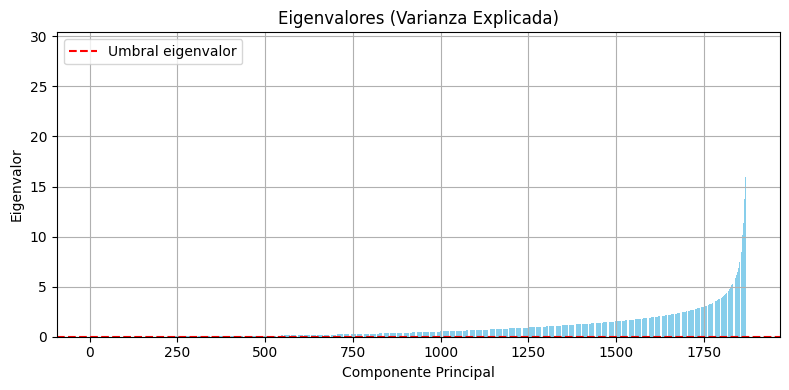


Traza (Varianza Total):
1873.6472011057363

Determinante:
0.0

Norma Frobenius:
88.28971682738465

Eigenvalores:
[-3.83385603e-16 -2.01385855e-16 -1.83157941e-16 ...  1.87484744e+01
  2.03215670e+01  2.89492426e+01]

Variables redundantes (producto interno):
['desarrollo tecnologico', 'laboratorio cadena', 'cierre llave', 'marcar positivo', 'descargar direccion', 'red contra', 'economica', 'custodiar bolsa', 'residencial actividad', 'signo', 'suministrar', 'vigilancia', 'diametro', 'usuario conforme', 'disminucion personal', 'sin ojal', 'comunitario', 'permitir', 'disponible', 'vivienda', 'cambio provisional', 'sin dejar', 'instalar sin', 'habitacion', 'serie retirar', 'posicion correcta', 'complementar', 'negativo prueba', 'remitir parar', 'imputada partir', 'temporal mentir', 'mediante cambio', 'manipulacion externa', 'no autorizado', 'servicio temporal', 'residencial momento', 'veredal', 'datos', 'suministran', 'observan', 'consumo avanzando', 'mayorca predio', 'bolsa seguridad', '

In [62]:
# Usamos el DataFrame de ejemplo creado antes
resultados = analisis_varianza_producto_interno(X_test_Filtradas)

# Mostramos el análisis
for k, v in resultados.items():
    print(f"\n{k}:\n{v}")

In [63]:
df_reducido = resultados['DataFrame reducido']

In [64]:
df_reducido.shape

(2895, 1642)

In [65]:
columnas_texto=df_reducido.columns.tolist()

In [66]:
X_categorical_df = pd.DataFrame(df[col_categoricas], columns=col_categoricas, index=df.index)
X_numerical_df = pd.DataFrame(df[col_numericas], columns=col_numericas, index=df.index)


In [67]:
# Concatenate the transformed features
# Ensure all dataframes have the same index for correct concatenation
X = pd.concat([X_categorical_df, X_numerical_df, df_reducido], axis=1)
y = df['CausaClasificada']
# Now X_processed contains your preprocessed features, and y contains your target variable
print("Shape of processed features (X_processed):", X.shape)
print("Shape of target variable (y):", y.shape)

# Display the first few rows of the processed features
display(X.head())



Shape of processed features (X_processed): (2895, 1651)
Shape of target variable (y): (2895,)


,Uso,Actividad Economica,Analisis Lectura,Ultimo Valor Leido,Diferencia Lectura,Dias entre lecturas,Promedio Dia Historico,Score Lectura,Score Promedio,barrio no,...,vivienda no,vivienda sin,vivir,vivir persona,vivir predio,vivir solo,volver,zona,zona agua,zona comun
0,Residencial,Otros Sectores,Parado,0.0,0.0,19.0,0.066667,10.0,7.0,0.0,...,0.0,0.336542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Otros Usos,Otros Sectores,Lectura Normal,3172.0,8.0,20.0,0.400000,3.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Residencial,Otros Sectores,Lectura Normal,3.0,14.0,13.0,0.200000,3.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Otros Usos,Otros Sectores,Lectura Normal,50739.0,50739.0,19.0,0.400000,3.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Otros Usos,Otros Sectores,Lectura Normal,16165.0,48.0,10.0,3.133333,3.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
%%bash
source ~/venv_spacy/bin/activate
pip install nltk --only-binary=:all:


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [69]:
from sklearn.preprocessing import StandardScaler,Normalizer,OneHotEncoder
from nltk import ConditionalProbDist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedKFold
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
#from sklearn.tree import export_graphviz
#from pydotplus import graph_from_dot_data
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [70]:
%%bash
source ~/venv_spacy/bin/activate
pip install imbalanced-learn --only-binary=:all:


In [71]:
from imblearn.over_sampling import SMOTE
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y)


In [72]:
X.dtypes

Uso                     object
Actividad Economica     object
Analisis Lectura        object
Ultimo Valor Leido     float64
Diferencia Lectura     float64
                        ...   
vivir solo             float64
volver                 float64
zona                   float64
zona agua              float64
zona comun             float64
Length: 1651, dtype: object

In [73]:
%%bash
source ~/venv_spacy/bin/activate
pip install xgboost --only-binary=:all:


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 136.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 59.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [74]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


In [75]:
import random
import numpy as np
import pandas as pd
import warnings

# --------------------------------------------------------------------
# Fijar semilla global para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [77]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import pandas as pd
import warnings


from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
try:
    from numpy.linalg import LinAlgWarning
    warnings.filterwarnings("ignore", category=LinAlgWarning)
except ImportError:
    # Si la versión de NumPy no define LinAlgWarning, lo omitimos
    pass
# --------------------------------------------------------------------



# Listas para almacenar los resultados finales
modelos_evaluados   = []
mejores_parametros  = []
score_train         = []
score_test          = []

# Columnas categóricas y numéricas
lista_categoricos = list(X_categorical_df.columns)
lista_numericos   = list(X_numerical_df.columns)

# --------------------------------------------------------------------
# 1) Definimos los pipelines de preprocesamiento
#    - Para variables numéricas: imputar (mediana) + estandarizar
#    - Para variables categóricas: imputar ("missing") + one‐hot encoding
# --------------------------------------------------------------------
numericos_transformados = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_transformados = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numericos_transformados, lista_numericos),
    ('cat', categorical_transformados, lista_categoricos)
])

# Validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------------------------------------------------
# 2) Diccionario de modelos con sus respectivas grillas de parámetros
#    Observación: en XGBoost ya no se usa 'use_label_encoder'; eliminamos esa opción.
# --------------------------------------------------------------------
modelos_parametros = {
    "RL": {
        "modelo": LogisticRegression(max_iter=1000),
        "param_grid": {
            'classifier__C':       [0.01, 0.1, 1],
            'classifier__solver':  ['lbfgs', 'liblinear'],
            'classifier__penalty': ['l2']
        }
    },

    "XGBoost": {
        "modelo": XGBClassifier(eval_metric='mlogloss'),
        "param_grid": {
            'classifier__n_estimators':   [100, 200, 300],
            'classifier__max_depth':      [3, 5, 7, 10],
            'classifier__learning_rate':  [0.01, 0.1, 0.2]
        }
    },

    "Tree": {
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [5, 10, 20]
        }
    },

    "SVC": {
        "modelo": SVC(),
        "param_grid": {
            'classifier__C':     [1, 10],
            'classifier__gamma': ['scale', 'auto']
        }
    },

    "RF": {
        "modelo": RandomForestClassifier(),
        "param_grid": {
            'classifier__n_estimators': [10, 50],
            'classifier__criterion':    ['gini', 'entropy'],
            'classifier__max_depth':    [5, 10]
        }
    },

    "LDA": {
        "modelo": LinearDiscriminantAnalysis(),
        "param_grid": {
            'classifier__solver': ['svd', 'lsqr']
        }
    },

    "QDA": {
        "modelo": QuadraticDiscriminantAnalysis(),
        "param_grid": {
            'classifier__reg_param': [0.1, 0.5, 1.0]  # Valores válidos en [0.0, 1.0]
        }
    }
}

# --------------------------------------------------------------------
# 3) Bucle de entrenamiento y evaluación con GridSearchCV
# --------------------------------------------------------------------
for nombre_modelo, contenido in modelos_parametros.items():
    print(f"\n----- Evaluando modelo: {nombre_modelo} -----")

    # Construir pipeline completo: preprocesador + clasificador
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier',  contenido["modelo"])
    ])

    # Configurar GridSearchCV
    grid = GridSearchCV(
        estimator=clf,
        param_grid=contenido["param_grid"],
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1
    )

    # Ajustar sobre el conjunto de entrenamiento
    grid.fit(X_train, y_train)

    # Mejor combinación encontrada y su score en validación interna
    mejores_param         = grid.best_params_
    score_entrenamiento   = grid.best_score_

    # Predecir sobre el conjunto de prueba con el mejor estimador
    clf_best = grid.best_estimator_
    y_pred   = clf_best.predict(X_test)
    score_prueba = f1_score(y_test, y_pred, average='macro')

    # Almacenar resultados
    modelos_evaluados.append(nombre_modelo)
    mejores_parametros.append(mejores_param)
    score_train.append(score_entrenamiento)
    score_test.append(score_prueba)

# --------------------------------------------------------------------
# 4) Construir DataFrame con los resultados finales
# --------------------------------------------------------------------
resultados = pd.DataFrame({
    "Modelo":             modelos_evaluados,
    "Mejores_Parametros": mejores_parametros,
    "F1_Train":           score_train,
    "F1_Test":            score_test
})



----- Evaluando modelo: RL -----

----- Evaluando modelo: XGBoost -----

----- Evaluando modelo: Tree -----

----- Evaluando modelo: SVC -----

----- Evaluando modelo: RF -----

----- Evaluando modelo: LDA -----

----- Evaluando modelo: QDA -----


In [78]:
X_train.head(5)

,Uso,Actividad Economica,Analisis Lectura,Ultimo Valor Leido,Diferencia Lectura,Dias entre lecturas,Promedio Dia Historico,Score Lectura,Score Promedio,barrio no,...,vivienda no,vivienda sin,vivir,vivir persona,vivir predio,vivir solo,volver,zona,zona agua,zona comun
1754,Residencial,Otros Sectores,Lectura Normal,933.0,12.0,26.0,0.366667,3.0,1.0,0.0,...,0.0,0.0,0.275747,0.302787,0.0,0.0,0.0,0.0,0.0,0.0
2455,Residencial,Otros Sectores,Lectura Baja,623.0,1.0,24.0,0.000000,5.0,1.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1452,Residencial,Otros Sectores,Lectura Baja,1046.0,1.0,9.0,0.266667,5.0,7.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2540,Residencial,Otros Sectores,Lectura Baja,419.0,4.0,50.0,0.033333,5.0,1.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1257,Residencial,Otros Sectores,Lectura Baja,0.0,1.0,58.0,0.166667,5.0,7.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
print("\n===== Resultados Finales =====")
print(resultados.sort_values("F1_Test", ascending=False))


===== Resultados Finales =====
    Modelo                                 Mejores_Parametros  F1_Train  \
1  XGBoost  {'classifier__learning_rate': 0.2, 'classifier...  0.565665   
2     Tree  {'classifier__criterion': 'entropy', 'classifi...  0.538357   
4       RF  {'classifier__criterion': 'entropy', 'classifi...  0.522824   
6      QDA                     {'classifier__reg_param': 1.0}  0.424232   
0       RL  {'classifier__C': 1, 'classifier__penalty': 'l...  0.448904   
5      LDA                     {'classifier__solver': 'lsqr'}  0.448560   
3      SVC  {'classifier__C': 10, 'classifier__gamma': 'au...  0.459346   

    F1_Test  
1  0.549030  
2  0.515370  
4  0.506957  
6  0.451664  
0  0.450622  
5  0.439128  
3  0.430566  


In [86]:
import boto3
from joblib import dump
from sklearn.pipeline import Pipeline

# 1) Encuentra el mejor modelo según tu DataFrame de resultados
resultados_df = resultados.sort_values("F1_Test", ascending=False)
mejor_modelo_nombre = resultados_df.iloc[0]["Modelo"]
print(f"Mejor modelo: {mejor_modelo_nombre}")

# 2) Obtén la instancia sin ajustar del modelo ganador
mejor_modelo_instance = modelos_parametros[mejor_modelo_nombre]["modelo"]

# 3) Define el pipeline final (preprocessor + clasificador ganador)
pipeline_final = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",  mejor_modelo_instance)
])

# 4) Ajusta (fit) el pipeline_final sobre todo X_train, y_train
pipeline_final.fit(X_train, y_train)

# 5) Guarda el pipeline entrenado en un archivo .joblib local
local_filename = "mejor_modelo_entrenado.joblib"
dump(pipeline_final, local_filename)
print(f"✅ Pipeline entrenado guardado localmente en ./{local_filename}")

# 6) Crea el cliente de S3 y sube ese .joblib al bucket/proyecto y carpeta “refined”
s3 = boto3.client("s3")
bucket_name = "proyectointegradorfinal"
s3_key     = "refined/mejor_modelo_entrenado.joblib"

s3.upload_file(local_filename, bucket_name, s3_key)
print(f"✅ Modelo subido a s3://{bucket_name}/{s3_key}")


Mejor modelo: XGBoost
✅ Pipeline entrenado guardado localmente en ./mejor_modelo_entrenado.joblib
✅ Modelo subido a s3://proyectointegradorfinal/refined/mejor_modelo_entrenado.joblib
